In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

os.getcwd()

'/Users/aneeshussain/Code/diss/analysis'

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Change directory to the parent directory (diss)
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
os.chdir(parent_dir)

# Append the parent directory to the system path (optional, if you want to add it to the import path)
sys.path.append(parent_dir)

# Print the new current working directory to confirm the change
print(f"Changed directory to: {os.getcwd()}")

Changed directory to: /Users/aneeshussain/Code/diss


Total Open Transaction Costs: 1658004.95
Total Close Transaction Costs: 1662601.65
Total Transaction Costs (Open + Close): 3320606.60


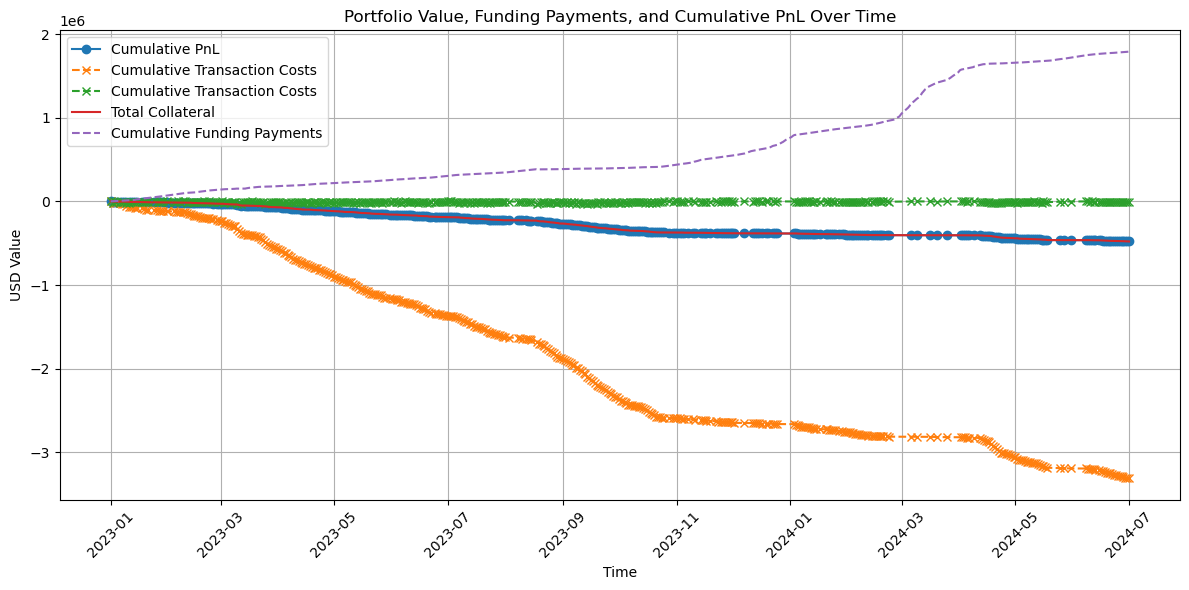

In [23]:
trades_filepath = './results/test1/trades_log.csv'
trades_df = pd.read_csv(trades_filepath)

# Convert 'close_time' to datetime and sort the trades by 'close_time'
trades_df['close_time'] = pd.to_datetime(trades_df['close_time'])
trades_df.sort_values(by='close_time', inplace=True)

# Extract date and calculate daily and cumulative PnL
trades_df['close_date'] = trades_df['close_time'].dt.date  # Get the date without time
daily_pnl = trades_df.groupby('close_date')['pnl'].sum()
cumulative_pnl = daily_pnl.cumsum()

# Calculate the total transaction cost (sum of open and close transaction costs)
trades_df['total_transaction_cost'] = trades_df['open_transaction_cost'] + trades_df['close_transaction_cost']

# Calculate the cumulative sum of transaction costs
daily_transaction_costs = trades_df.groupby('close_date')['total_transaction_cost'].sum()
cumulative_transaction_costs = daily_transaction_costs.cumsum()


# Load the collateral and funding payment CSV
collateral_filepath = './results/test1/collateral_log.csv'
df = pd.read_csv(collateral_filepath)

# Convert 'time' to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Select the collateral columns to calculate the total collateral value
collateral_columns = [
    'binance_btc_collateral', 'binance_eth_collateral', 'binance_liquid_cash', 
    'okx_btc_collateral', 'okx_eth_collateral', 'okx_liquid_cash', 
    'bybit_btc_collateral', 'bybit_eth_collateral', 'bybit_liquid_cash'
]

# Calculate total collateral and funding payments
df['total_collateral'] = df[collateral_columns].sum(axis=1) - 10000000
df['total_funding_payments'] = df[['binance_funding', 'okx_funding', 'bybit_funding']].sum(axis=1)

total_open_transaction_cost = trades_df['open_transaction_cost'].sum()
total_close_transaction_cost = trades_df['close_transaction_cost'].sum()

# Print the sums
print(f"Total Open Transaction Costs: {total_open_transaction_cost:.2f}")
print(f"Total Close Transaction Costs: {total_close_transaction_cost:.2f}")

# Calculate and print the total transaction costs (open + close)
total_transaction_cost = total_open_transaction_cost + total_close_transaction_cost
print(f"Total Transaction Costs (Open + Close): {total_transaction_cost:.2f}")

# Plot the cumulative PnL, total collateral, and funding payments on the same graph
plt.figure(figsize=(12, 6))

# Plot cumulative PnL (using the close date as x-axis)
plt.plot(cumulative_pnl.index, cumulative_pnl.values, label='Cumulative PnL', marker='o')

# Plot cumulative transaction costs
plt.plot(cumulative_transaction_costs.index, -cumulative_transaction_costs.values, label='Cumulative Transaction Costs', linestyle='--', marker='x')

# Plot cumulative transaction costs
plt.plot(daily_transaction_costs.index, -daily_transaction_costs.values, label='Cumulative Transaction Costs', linestyle='--', marker='x')



# Plot total collateral
plt.plot(df.index, df['total_collateral'], label='Total Collateral', linestyle='-')

# Plot cumulative funding payments
plt.plot(df.index, df['total_funding_payments'], label='Cumulative Funding Payments', linestyle='--')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('USD Value')
plt.title('Portfolio Value, Funding Payments, and Cumulative PnL Over Time')
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

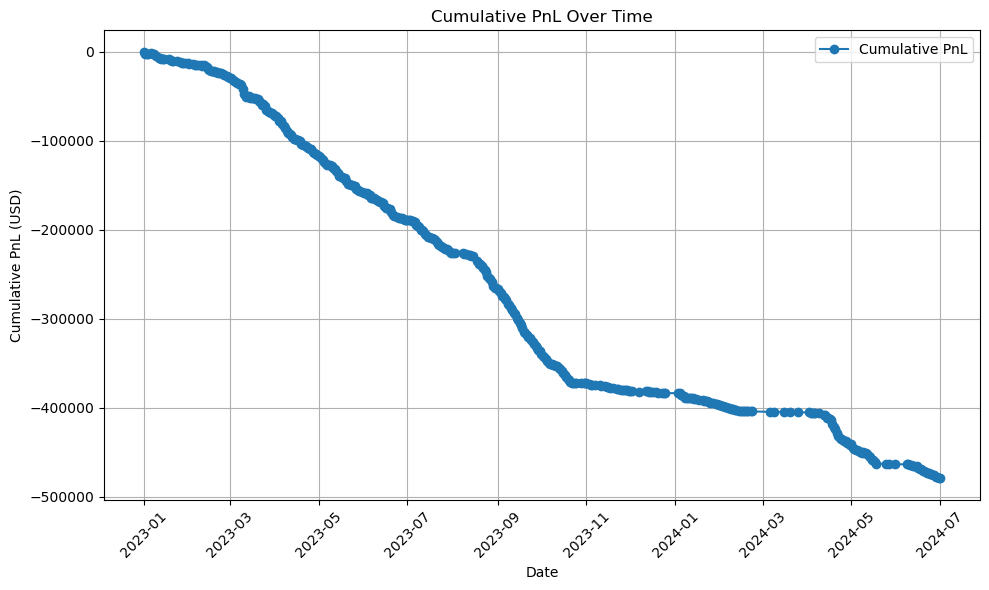

In [11]:
filepath = './results/test1/trades_log.csv'

trades_df = pd.read_csv(filepath)
# Convert 'close_time' to datetime
trades_df['close_time'] = pd.to_datetime(trades_df['close_time'])

# Sort by 'close_time' to ensure trades are in the correct order
trades_df.sort_values(by='close_time', inplace=True)

# Group by 'close_time' to sum PnL by date (optional, can skip this step if you want individual trades)
trades_df['close_date'] = trades_df['close_time'].dt.date  # Get the date without time
daily_pnl = trades_df.groupby('close_date')['pnl'].sum()

# Calculate the cumulative sum of PnL to reflect total capital change over time
cumulative_pnl = daily_pnl.cumsum()

# Plot the cumulative PnL
plt.figure(figsize=(10, 6))
plt.plot(cumulative_pnl.index, cumulative_pnl.values, label='Cumulative PnL', marker='o')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (USD)')
plt.title('Cumulative PnL Over Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

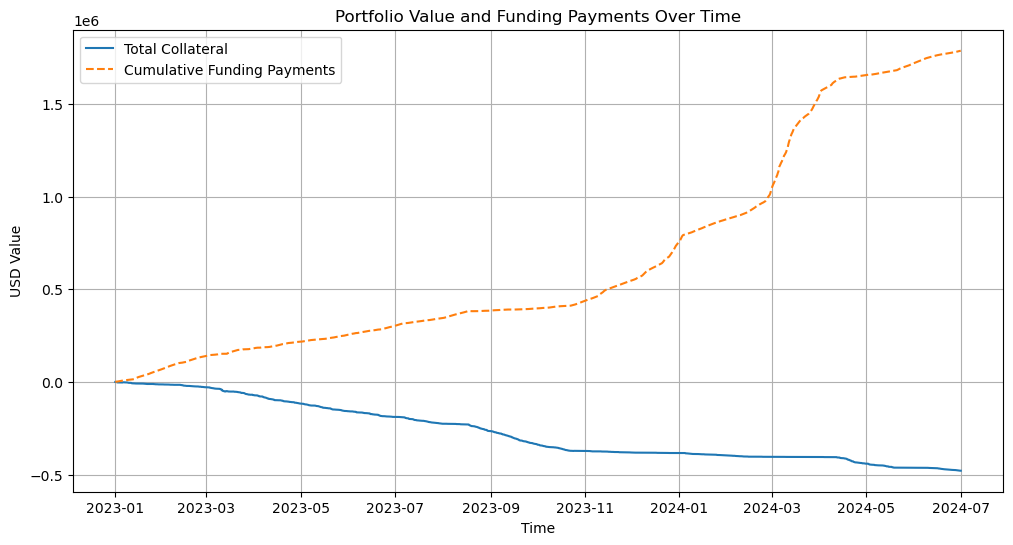

In [10]:
# Load the CSV file containing collateral and funding payment data
filepath = './results/test1/collateral_log.csv'

df = pd.read_csv(filepath)

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# Set 'time' as the index for easier plotting
df.set_index('time', inplace=True)

# Select the collateral columns to calculate the total collateral value
collateral_columns = [
    'binance_btc_collateral', 'binance_eth_collateral', 'binance_liquid_cash', 
    'okx_btc_collateral', 'okx_eth_collateral', 'okx_liquid_cash', 
    'bybit_btc_collateral', 'bybit_eth_collateral', 'bybit_liquid_cash'
]

# Calculate the total collateral at each time step
df['total_collateral'] = df[collateral_columns].sum(axis=1) - 10000000

# Calculate cumulative funding payments for the different exchanges
df['total_funding_payments'] = df[['binance_funding', 'okx_funding', 'bybit_funding']].sum(axis=1)
# df['funding_cumsum'] = df['total_funding_payments'].cumsum()

# Plot the total collateral and funding payments
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['total_collateral'], label='Total Collateral')
plt.plot(df.index, df['total_funding_payments'], label='Cumulative Funding Payments', linestyle='--')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('USD Value')
plt.title('Portfolio Value and Funding Payments Over Time')
plt.grid(True)
plt.legend()

plt.show()

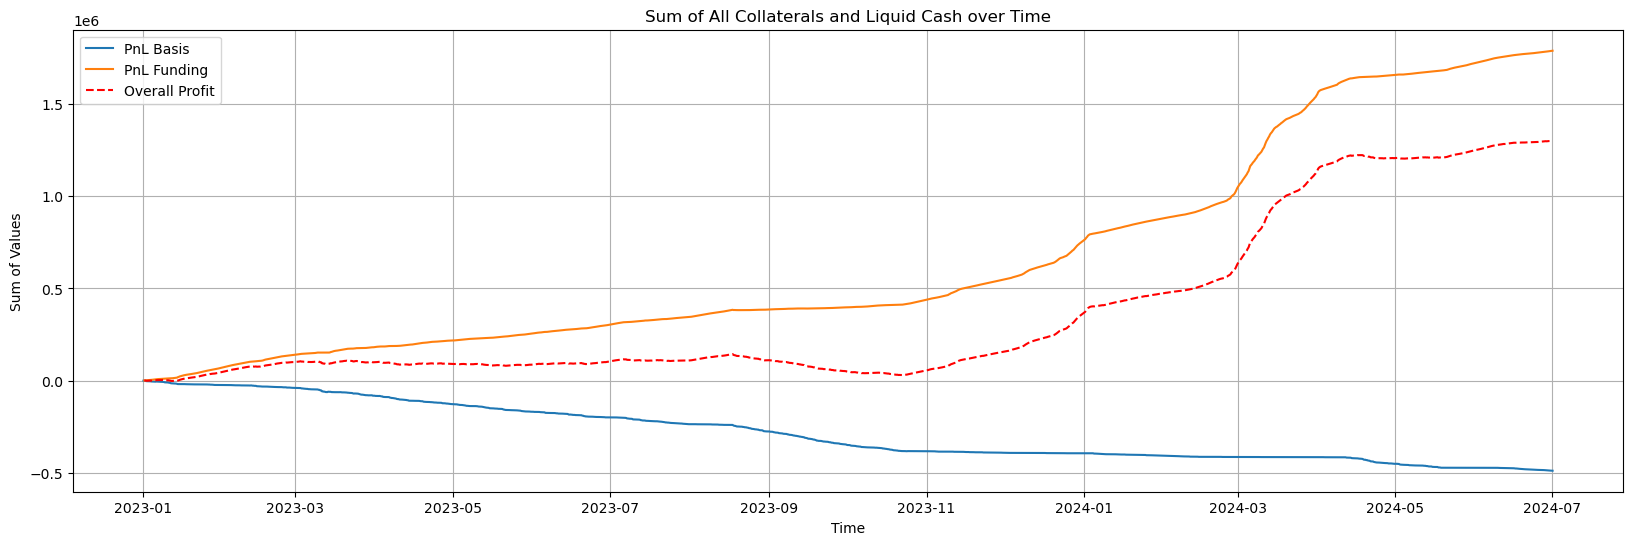

In [4]:
filepath1 = './data/logging/collateral_values_log.csv'
filepath2 = './data/logging/funding_payments_log.csv'

df1 = pd.read_csv(filepath1)
df2 = pd.read_csv(filepath2)

df1['time'] = pd.to_datetime(df1['time'])
df2['time'] = pd.to_datetime(df2['time'])

# Set the 'time' column as the index for easier plotting
df1.set_index('time', inplace=True)
df2.set_index('time', inplace=True)

# # Select the columns representing the collaterals
# collateral_columns = [
#     'binance_btc_collateral', 'binance_eth_collateral', 'binance_liquid_cash', 
#     'okx_btc_collateral', 'okx_eth_collateral', 'okx_liquid_cash', 
#     'bybit_btc_collateral', 'bybit_eth_collateral', 'bybit_liquid_cash'
# ]

# # Calculate the sum of all collaterals for each time step (total portfolio value)
# df1['total_collateral'] = df1[collateral_columns].sum(axis=1)

# # Calculate the percentage of each collateral relative to the total portfolio value
# for col in collateral_columns:
#     df1[col + '_pct'] = df1[col] / df1['total_collateral'] * 100

# # Increase plot size to make the bars more readable
# plt.figure(figsize=(12, 6))

# # Plot a stacked bar chart for each collateral over time
# df1[[col + '_pct' for col in collateral_columns]].plot(kind='bar', stacked=True, ax=plt.gca(), width=1)

# # Reduce the number of x-ticks to avoid crowding
# plt.xticks(ticks=range(0, len(df1.index), 10), labels=df1.index[::10].strftime('%Y-%m-%d'), rotation=45)

# # Add gridlines for better readability
# plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# # Customize the plot
# plt.xlabel('Time')
# plt.ylabel('Portfolio Weighting (%)')
# plt.title('Portfolio Weighting of Collaterals Over Time')
# plt.legend(title='Collaterals', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
# plt.tight_layout()


df1['sum_all_values'] = df1.sum(axis=1)
df1['pnl_basis'] = df1['sum_all_values'] - 10000000

funding_payment_sums = df2.groupby('time')['funding payment'].sum()
funding_payment_cumsum = funding_payment_sums.cumsum()

aligned_funding_cumsum, aligned_pnl_basis = funding_payment_cumsum.align(df1['pnl_basis'], join='inner')
overall_profit = aligned_funding_cumsum + aligned_pnl_basis

pnl_sums = df2.groupby('time')['pnl'].sum()
pnl_cumsum = pnl_sums.cumsum()

# Plot the sum at each timestamp
plt.figure(figsize=(20, 6))
plt.plot(df1.index, df1['pnl_basis'], label='PnL Basis')
plt.plot(funding_payment_cumsum.index, funding_payment_cumsum.values, label='PnL Funding')
# plt.plot(pnl_cumsum.index, pnl_cumsum.values, label='PnL Realized')
plt.plot(overall_profit.index, overall_profit.values, label='Overall Profit', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Sum of Values')
plt.title('Sum of All Collaterals and Liquid Cash over Time')
plt.grid(True)
plt.legend()

plt.show()

In [4]:
rf_df = pd.read_excel('./data/raw/Search.xlsx')


# new_df['Effective Date'] = pd.to_datetime(rf_df['Effective Date']).dt.strftime('%Y-%m-%d')


# Create a new DataFrame with only the transformed Date and Rate columns
new_df = pd.DataFrame()
new_df['date'] = pd.to_datetime(rf_df['Effective Date'])
new_df['rate'] = rf_df['Rate (%)'] / 100

# Sort the DataFrame by date in ascending order
new_df = new_df.sort_values('date')

# Create a date range that covers all dates between the min and max date in the data
all_dates = pd.date_range(start=new_df['date'].min(), end=new_df['date'].max())

# Reindex the DataFrame to include all dates, forward fill the missing rates
new_df = new_df.set_index('date').reindex(all_dates).fillna(method='ffill')

# Reset the index and rename the index column back to 'Effective Date'
new_df = new_df.rename_axis('date').reset_index()

new_df.to_csv('./data/processed/risk_free_rate.csv', index=False)

/Applications/anaconda3/envs/sklearn0242/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/mf/b67_blxs1rj380h3rh2kgtlh0000gn/T/ipykernel_65652/2324242968.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df = new_df.set_index('date').reindex(all_dates).fillna(method='ffill')


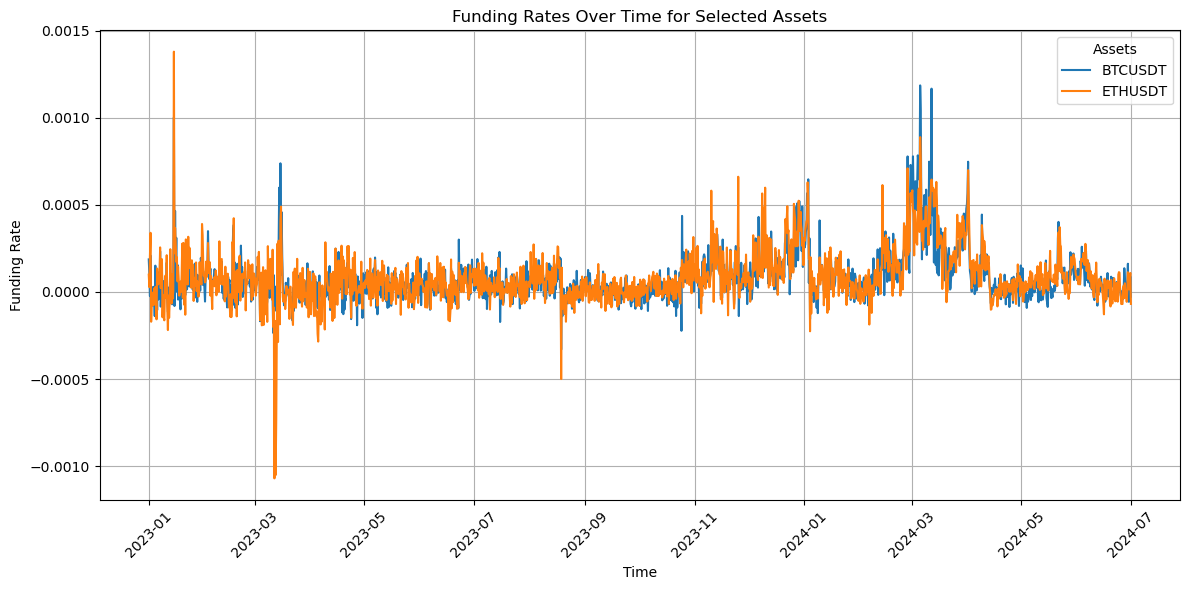

In [6]:
df = pd.read_csv('./data/processed/okx.csv')

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# Filter for the 4 assets you're interested in
# assets_of_interest = ['BTCUSDCM', 'BTCUSDT', 'ETHUSDCM', 'ETHUSDT']  # Replace with your actual asset names
assets_of_interest = ['BTCUSDT', 'ETHUSDT'] 
filtered_df = df[df['pair'].isin(assets_of_interest)]

# Plot funding rates for each asset
plt.figure(figsize=(12, 6))

for asset in assets_of_interest:
    asset_data = filtered_df[filtered_df['pair'] == asset]
    plt.plot(asset_data['time'], asset_data['funding rate'], label=asset)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Funding Rate')
plt.title('Funding Rates Over Time for Selected Assets')
plt.legend(title='Assets')

# Display the plot
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

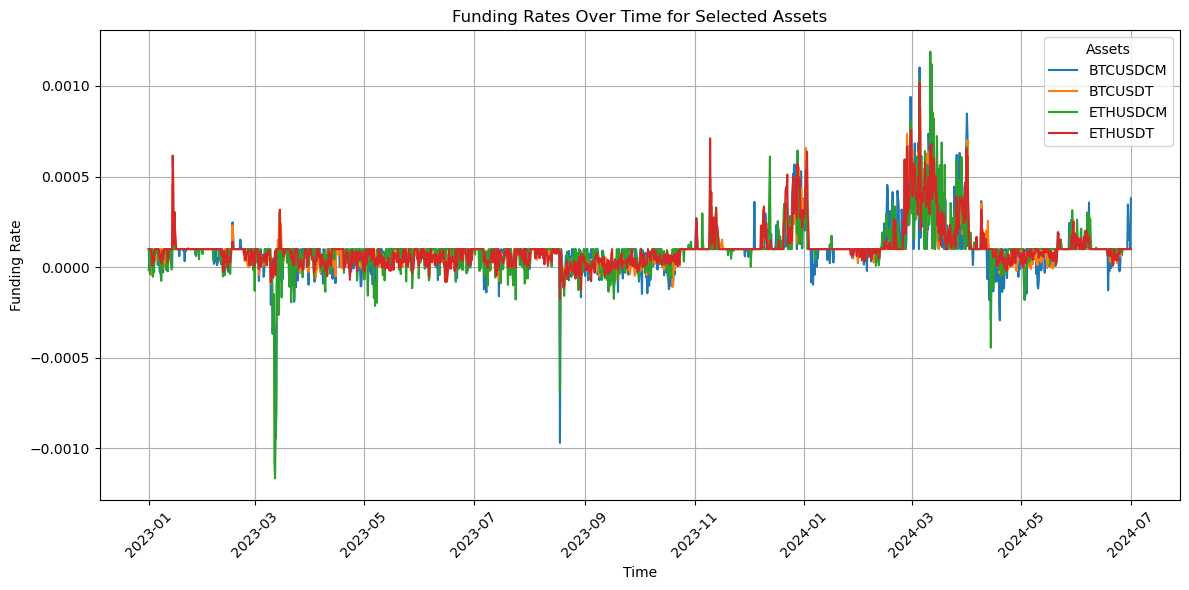

In [4]:
df = pd.read_csv('./data/processed/binance.csv')

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# Filter for the 4 assets you're interested in
assets_of_interest = ['BTCUSDCM', 'BTCUSDT', 'ETHUSDCM', 'ETHUSDT']  # Replace with your actual asset names
filtered_df = df[df['pair'].isin(assets_of_interest)]

# Plot funding rates for each asset
plt.figure(figsize=(12, 6))

for asset in assets_of_interest:
    asset_data = filtered_df[filtered_df['pair'] == asset]
    plt.plot(asset_data['time'], asset_data['funding rate'], label=asset)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Funding Rate')
plt.title('Funding Rates Over Time for Selected Assets')
plt.legend(title='Assets')

# Display the plot
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

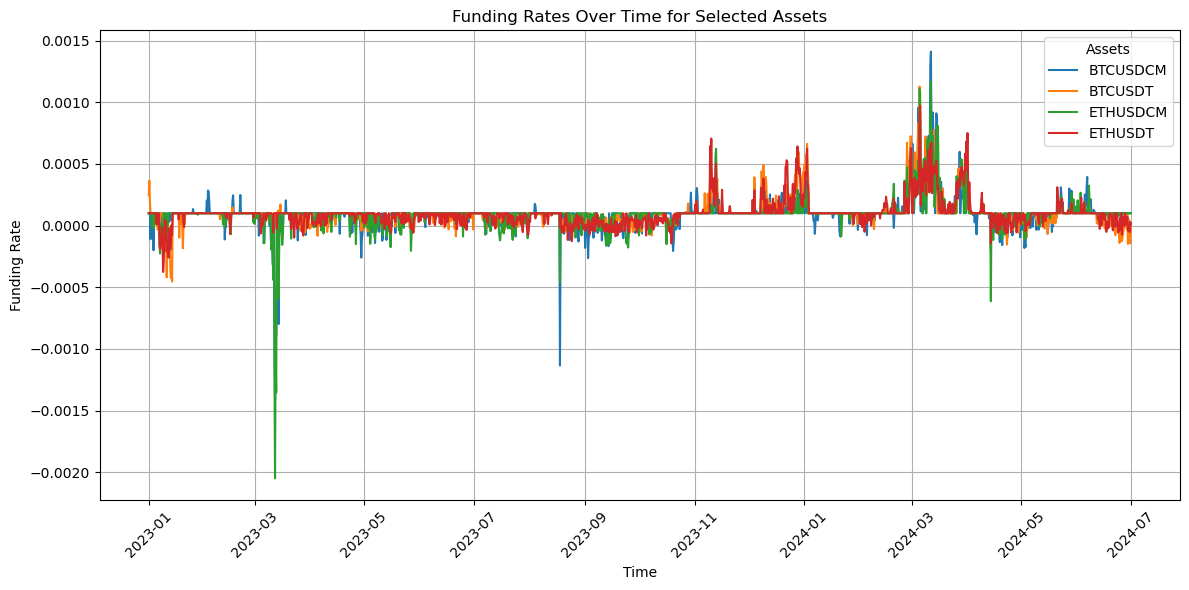

In [5]:
df = pd.read_csv('./data/processed/bybit.csv')

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# Filter for the 4 assets you're interested in
assets_of_interest = ['BTCUSDCM', 'BTCUSDT', 'ETHUSDCM', 'ETHUSDT']  # Replace with your actual asset names
filtered_df = df[df['pair'].isin(assets_of_interest)]

# Plot funding rates for each asset
plt.figure(figsize=(12, 6))

for asset in assets_of_interest:
    asset_data = filtered_df[filtered_df['pair'] == asset]
    plt.plot(asset_data['time'], asset_data['funding rate'], label=asset)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Funding Rate')
plt.title('Funding Rates Over Time for Selected Assets')
plt.legend(title='Assets')

# Display the plot
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()